In [1]:
import pandas as pd
import matplotlib as mpl
from matplotlib import animation
import imageio_ffmpeg
from statsbombpy import sb
from mplsoccer import Pitch
import json
from pathlib import Path
import numpy as np
import warnings
import matplotlib.patheffects as PathEffects

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


from auxiliar_functions import *

### Pass Risk Measure – Concept
The goal is to approximate StatsBomb’s proprietary pass difficulty metrics (e.g. xPass, OBV) with a simplified model. The idea behind pass risk definition is the likelihood a pass will *fail*, given its contextual environment. Contextual factors considered are pass length and height, angle, bypassed opponents, field zone (for both origin and destination), and pressure (by nearest-defender distance).


In [2]:
data_dir = Path("data/italy_euro2020")
matches_file = data_dir / "matches/55/43.json"

In [3]:
# %run download_italy_euro2020_data.py

In [4]:
# Build files summary
matches = json.loads(matches_file.read_text(encoding="utf-8"))
df = pd.json_normalize(matches)

cols = [
    "match_id",
    "match_date",
    "competition_stage.name",
    "home_team.home_team_name",
    "away_team.away_team_name",
]
df = df[cols].rename(columns={  "competition_stage.name": "stage",
                                "home_team.home_team_name": "home",
                                "away_team.away_team_name": "away",
                                })


df = df[(df["home"] == "Italy") | (df["away"] == "Italy")].sort_values("match_date").reset_index(drop=True)
match_ids = df["match_id"].tolist()

summary_rows = []
for id in match_ids:
    event = file_exists(data_dir / "events" / f"{id}.json")
    lineup = file_exists(data_dir / "lineups" / f"{id}.json")
    fr_path = data_dir / "three-sixty" / f"{id}.json"
    fr_exists = file_exists(fr_path)
    n_frames = count_freeze_frames(id, data_dir) if fr_exists else 0
    summary_rows.append({
        "match_id": id,
        "events.json": event,
        "lineups.json": lineup,
        "three-sixty.json": fr_exists,
        "frames_count": n_frames,
    })

# Merge into the main DataFrame
availability = pd.DataFrame(summary_rows)
df = df.merge(availability, on="match_id")

print("Italy Euro 2020 matches data availability summary:")
display(df)

Italy Euro 2020 matches data availability summary:


,match_id,match_date,stage,home,away,events.json,lineups.json,three-sixty.json,frames_count
0,3788741,2021-06-11,Group Stage,Turkey,Italy,True,True,True,3370
1,3788754,2021-06-16,Group Stage,Italy,Switzerland,True,True,True,3423
2,3788766,2021-06-20,Group Stage,Italy,Wales,True,True,True,2800
3,3794685,2021-06-26,Round of 16,Italy,Austria,True,True,True,4456
4,3795107,2021-07-02,Quarter-finals,Belgium,Italy,True,True,True,2965
5,3795220,2021-07-06,Semi-finals,Italy,Spain,True,True,True,4247
6,3795506,2021-07-11,Final,Italy,England,True,True,True,4303


**Data preprocessing**

Filtering and feature engineering steps necessary to obtain relevant features for this analysis.

In [5]:
features = [
        "id", "minute", "second", "time", "team", "player_name", "sx", "sy", "recipient", "ex", "ey",
        "dx", "dy", "length", "angle", "direction", "is_progressive", "height",
        "is_cross", "is_through", "zone_origin", "zone_dest", "is_complete"
    ]

pressure_thr = 2.5          # in meters
bypass_margin_thr = 2.0     # in meters

pass_events = []
lineups_list = []
frames_list = []
for id in match_ids:
    ev = load_events(id, data_dir)
    lineup = load_lineups(id, data_dir)
    frames = load_360(id, data_dir)
    pass_features = pass_features_from_events(ev, features)
    pass_features["match_id"] = id
    pass_events.append(pass_features)
    lineups_list.append(lineup)
    frames_list.append(frames)


df_pass = pd.concat(pass_events, ignore_index=True).reset_index(drop=True)
df_lineups = pd.concat(lineups_list, ignore_index=True).reset_index(drop=True)
df_frames = pd.concat(frames_list, ignore_index=True).reset_index(drop=True)

df_pass = df_pass.merge(df[["match_id", "home", "away", "stage"]], on="match_id", how="left")
df_pass = df_pass.merge(df_lineups[['match_id', 'player_name', 'jersey_number']], on=['match_id', 'player_name'], how='left')
df_pass = df_pass.merge(df_lineups[['match_id', 'player_name', 'jersey_number']], left_on=['match_id', 'recipient'], right_on=['match_id', 'player_name'], how='left')

df_frames = df_frames.merge(df_pass[['id','sx','sy','ex','ey']], left_on='event_index', right_on='id', how='right')
df_360 = (
    df_frames.groupby("event_index", sort=False)
            .apply(pressure_metrics, pressure_thr=pressure_thr, bypass_margin_thr=bypass_margin_thr)
            .reset_index()
            .rename(columns={"event_index": "id"})
)
df_pass = df_pass.merge(df_360, on="id", how="left")
df_pass['passer_pressure'] = df_pass['passer_pressure'].fillna(0).astype(int)
df_pass['receiver_pressure'] = df_pass['receiver_pressure'].fillna(0).astype(int)
df_pass['bypassed_opponents'] = df_pass['bypassed_opponents'].fillna(0).astype(int)


df_pass = df_pass.rename(columns={  "player_name_x": "player_name",
                                    "jersey_number_x": "jersey_number",
                                    "jersey_number_y": "jersey_number_receiver"})
df_pass = df_pass.drop(columns={'player_name_y'})
df_pass["jersey_number"] = df_pass["jersey_number"].astype(int)
df_pass["jersey_number_receiver"] = df_pass["jersey_number_receiver"].fillna(0).astype(int)


#reorder final columns
final_cols = ["minute", "second", "time", "stage", "team", "home", "player_name", "jersey_number", "sx", "sy", "recipient", "jersey_number_receiver", "ex", "ey",
        "dx", "dy", "length", "angle", "direction", "is_progressive", "height", "is_cross", "is_through", "zone_origin", "zone_dest", "is_complete",
        "passer_pressure", "passer_pressure_dist", "receiver_pressure", "receiver_pressure_dist", "bypassed_opponents"
    ]
df_pass = df_pass[final_cols]

display(df_pass.head(3))

,minute,second,time,stage,team,home,player_name,jersey_number,sx,sy,recipient,jersey_number_receiver,ex,ey,dx,dy,length,angle,direction,is_progressive,height,is_cross,is_through,zone_origin,zone_dest,is_complete,passer_pressure,passer_pressure_dist,receiver_pressure,receiver_pressure_dist,bypassed_opponents
0,0,0,00:00,Group Stage,Turkey,Turkey,Burak Yılmaz,17,60.0,40.0,Caglar Söyüncü,4,32.5,28.8,-27.5,-11.2,29.693265,-2.754832,backward,False,Ground Pass,False,False,middle,defensive,True,0,8.700299,0,11.600015,2
1,0,4,00:04,Group Stage,Turkey,Turkey,Caglar Söyüncü,4,36.2,30.4,Kenan Karaman,9,70.7,75.8,34.5,45.4,57.021136,0.920982,forward,True,High Pass,False,False,defensive,middle,True,0,5.362913,0,30.067519,1
2,0,12,00:12,Group Stage,Italy,Turkey,Leonardo Spinazzola,4,43.1,0.1,Giorgio Chiellini,3,15.8,7.5,-27.3,7.4,28.285155,2.876891,backward,False,Low Pass,False,False,middle,defensive,True,0,9.050701,0,22.591962,0


**Risk Quantification**

Attributes preparation to build risk pass metric. Metrics considered (*length*, *angle*, *passer_preassure*, *passer_pressure_distance*, *receiver_pressure*, *receiver_pressure_distance*, and *bypassed_opponents*) are normalized using Min-Max normalization formula, and combined with user-biased weighting to compute risk metric.

In [6]:
df_pass.columns

Index(['minute', 'second', 'time', 'stage', 'team', 'home', 'player_name',
       'jersey_number', 'sx', 'sy', 'recipient', 'jersey_number_receiver',
       'ex', 'ey', 'dx', 'dy', 'length', 'angle', 'direction',
       'is_progressive', 'height', 'is_cross', 'is_through', 'zone_origin',
       'zone_dest', 'is_complete', 'passer_pressure', 'passer_pressure_dist',
       'receiver_pressure', 'receiver_pressure_dist', 'bypassed_opponents'],
      dtype='object')

In [7]:
def pass_risk_metric(df: pd.DataFrame, metrics: dict[str, float], flip_values: np.array):
    
    risk = pd.Series(0, index=df.index)

    for m in metrics.keys():
        norm_m = (df[m]-df[m].min()) / (df[m].max()-df[m].min())
        norm_m = norm_m.fillna(0.0)
        
        if m in flip_values:
            norm_m = 1.0 - norm_m
        
        risk = risk + norm_m*metrics[m]
    
    return risk


cols = {'length':0.3, 'passer_pressure': 0.1, 'passer_pressure_dist':0.1, 'receiver_pressure':0.1, 'receiver_pressure_dist':0.1, 'bypassed_opponents':0.3}
metrics_to_flip = ['passer_pressure_dist', 'receiver_pressure_dist']    # lower values are riskier than higher values
df_pass["risk_measure"] = pass_risk_metric(df=df_pass, metrics=cols, flip_values=metrics_to_flip)



In [8]:
df_pass.head(3)

,minute,second,time,stage,team,home,player_name,jersey_number,sx,sy,recipient,jersey_number_receiver,ex,ey,dx,dy,length,angle,direction,is_progressive,height,is_cross,is_through,zone_origin,zone_dest,is_complete,passer_pressure,passer_pressure_dist,receiver_pressure,receiver_pressure_dist,bypassed_opponents,risk_measure
0,0,0,00:00,Group Stage,Turkey,Turkey,Burak Yılmaz,17,60.0,40.0,Caglar Söyüncü,4,32.5,28.8,-27.5,-11.2,29.693265,-2.754832,backward,False,Ground Pass,False,False,middle,defensive,True,0,8.700299,0,11.600015,2,0.343382
1,0,4,00:04,Group Stage,Turkey,Turkey,Caglar Söyüncü,4,36.2,30.4,Kenan Karaman,9,70.7,75.8,34.5,45.4,57.021136,0.920982,forward,True,High Pass,False,False,defensive,middle,True,0,5.362913,0,30.067519,1,0.364102
2,0,12,00:12,Group Stage,Italy,Turkey,Leonardo Spinazzola,4,43.1,0.1,Giorgio Chiellini,3,15.8,7.5,-27.3,7.4,28.285155,2.876891,backward,False,Low Pass,False,False,middle,defensive,True,0,9.050701,0,22.591962,0,0.241370


**Pass Map Animation Preparation**

The idea is to build pass sequences and risk quantification in Euro2020 final match.

In [9]:
n_passes_in_viz = 3
pitch_length = 120
pitch_width = 80
visual_measure = 'risk_measure'

team_color = {
    'italy': '#1f77b4',
    'opponent': "#ffffff",
}

pass_outcome_color = {
    'successful': "#32BE32",
    'fail': "#fa4e4e",
}


MovieWriter stderr:
[AVFormatContext @ 000001ba41d38400] Unable to choose an output format for 'euro2020_final_pass_animation.git'; use a standard extension for the filename or specify the format manually.
[out#0 @ 000001ba41d22f40] Error initializing the muxer for euro2020_final_pass_animation.git: Invalid argument
Error opening output file euro2020_final_pass_animation.git.
Error opening output files: Invalid argument



CalledProcessError: Command '['c:\\Users\\pujol\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\imageio_ffmpeg\\binaries\\ffmpeg-win-x86_64-v7.1.exe', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '700x500', '-pix_fmt', 'rgba', '-framerate', '1', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-y', 'euro2020_final_pass_animation.git']' returned non-zero exit status 4294967274.

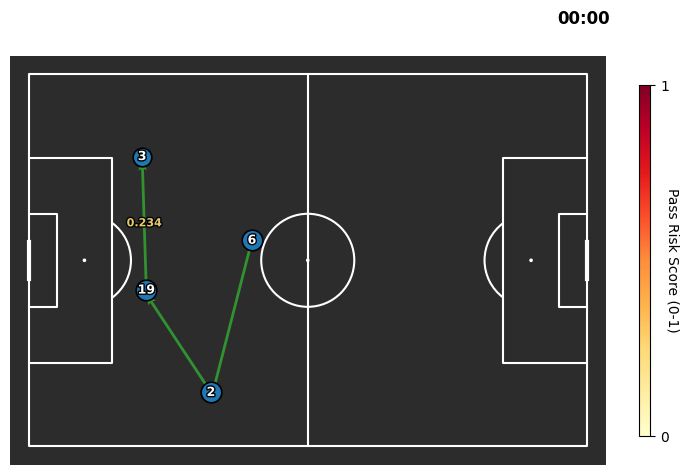

In [14]:
df_final = df_pass[df_pass["stage"]=="Final"]

#flip away team locations
is_away = df_final['team']!=df_final['home']
df_final.loc[is_away, ["sx","ex"]] = pitch_length - df_final.loc[is_away, ["sx","ex"]]
df_final.loc[is_away, ["sy","ey"]] = pitch_width - df_final.loc[is_away, ["sy","ey"]]

df_final = df_final.sort_values(['minute','second']).reset_index(drop=True)

pitch = Pitch(pitch_type="statsbomb", pitch_color="#2C2C2C", line_color='white', linewidth=1.5)
fig, ax = pitch.draw(figsize=(7,5))
time_text = ax.text(
    pitch_length+5, -10, "",
    ha="right", va="bottom",
    fontsize=12, color="black", weight="bold"
)

cmap = mpl.cm.get_cmap('YlOrRd')
norm = mpl.colors.Normalize(vmin=0., vmax=1.0)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.05, pad=0.05, shrink=0.8, aspect=30)
cbar.set_ticks([0.0, 1.0])
cbar.set_label("Pass Risk Score (0-1)", rotation=270, labelpad=8, color="black")
for t in cbar.ax.get_yticklabels():
    t.set_color("black")
cbar.outline.set_edgecolor("black")

metric_text = ax.text(
    60, 40, "", 
    ha="center", va="center",
    fontsize=8, color="yellow", weight="bold",
    alpha=0.9, zorder=8
)
metric_text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground="black")])

visualize_frames = []
player_markers = {}

def animate(i):

    if i==0:
        time_text.set_text('00:00')
        return ax,

    row = df_final.iloc[i-1]
    time_text.set_text(row['time'])
    pass_color = pass_outcome_color['successful'] if row['is_complete']==True else pass_outcome_color['fail']
    player_color = team_color['italy'] if row['team']=='Italy' else team_color['opponent']

    frame = []

    #draw pass
    pass_arrow = pitch.arrows(row['sx'], row['sy'], row['ex'], row['ey'],
                        color=pass_color, ax=ax, 
                        alpha=0.7 if bool(row["is_complete"]) else 0.5,
                        linestyle="-" if bool(row["is_complete"]) else "--",
                        width=2)
    mx, my = (row['sx'] + row['ex'])/2, (row['sy'] + row['ey'])/2
    # update the distance text
    metric_text.set_position((mx, my))
    metric_text.set_text(f"{row[visual_measure]:.3f}")
    metric_text.set_color(cmap(norm(row[visual_measure])))
    frame.append(pass_arrow)

    #draw action player
    player_circle = draw_numbered_circle(ax,
                            x=row["sx"], y=row["sy"],
                            number=row["jersey_number"],
                            facecolor=player_color)
    frame.extend(player_circle)
    update_player_markers(player_markers=player_markers, 
                          player_name=row['player_name'], 
                          x=row['sx'], 
                          y=row['sy'], 
                          circle=player_circle, 
                          number=row['jersey_number'])
    
    #draw receiver player
    if row['is_complete']==True:
        receiver_circle = draw_numbered_circle(ax, row["ex"], row["ey"],
                                    number=row["jersey_number_receiver"],
                                    facecolor=player_color, size=180)
        frame.extend(receiver_circle)
        update_player_markers(player_markers=player_markers, 
                              player_name=row["recipient"], 
                              x=row["ex"], 
                              y=row["ey"], 
                              circle=receiver_circle, 
                              number=row["jersey_number_receiver"])
    
    visualize_frames.append(frame)
    if len(visualize_frames) > n_passes_in_viz:
        old = visualize_frames.pop(0)
        for art in old:
            try:
                art.remove()
            except Exception:
                pass


    return ax,


ani = animation.FuncAnimation(fig, animate,
                              frames=len(df_final),
                              interval=80,
                              blit=False,
                              repeat=False)

# save file
ffmpeg_path = imageio_ffmpeg.get_ffmpeg_exe()
mpl.rcParams["animation.ffmpeg_path"] = ffmpeg_path
writer = animation.FFMpegWriter(fps=1, bitrate=1800)
ani.save('euro2020_final_pass_animation.git', writer=writer)
df_final.to_csv("euro2020_final_pass_events.csv", index=False)

*All distances are expressed in StatsBomb pitch units (0–120 x 0–80), and although they approximately correspond to meters on a full-size pitch, it is not guaranteed that the measures really correspond to meters.*